# Predict Airbnb Listings' Availability in San Francisco
*Springboard Capstone Project I*

*Fan Dong*

## I. Introduction

This project aims to build a machine learning model that predicts the availability of Airbnb listings in San Francisco. Given a listing and a range of dates, the model will be able to tell you whether this place will be available on these dates. 

The model makes use of detailed listing information, as well as their daily availability info from September 2015 to September 2017. With careful data processing, feature engineering and model fitting, the model achieves relatively high accuracy and provides many interesting insights regarding Airbnb and the 'Accommodation Sharing Economy'. 

Of course, we are not building model for the sake of achieving high accuracy score. The model has many real-life applications. For example, hosts can use it to learn their places' projected booking rate and value; more importantly, they can explore the relation between booking rate and their places' key info (price, # of bed, location, key amenities, etc.) and thus make improvements to attract more guests and increase total revenue. 

While focusing on the San Francisco market for now, the model can potentially be expanded to many other cities, depending on data availability. As of now, we choose San Francisco out of two considerations: 1). data completeness: SF's Airbnb listing data are scraped monthly, providing the most updated information on listing availability; many other cities' data are updated every two or three months, or even longer. 2). Airbnb started its business in San Francisco. This city is their most mature market. Therefore we expect San Francisco's data to be the most diverse and complete, which is crucial for us to train a model that covers a variety of property types and targets a variety of customer groups. 

The project has three groups of potential audience in mind:

- For Airbnb hosts and guests, who are the direct customers of this model. 

- For decision-makers at Airbnb, knowing their listings' projected value enables the company to “allocate budget across different marketing channels more efficiently, calculate more precise bidding prices for online marketing based on keywords, and create better listing segments.”

- For anybody interested in this company, a model that predicts Airbnb listing's availability and projects its future value enables them to better understand its business model as well as the emerging 'Accommodation Sharing Economy'. We all know Airbnb will go public someday; it's better to start understand their business now.

This report serves as a detailed documentation of the project. It is structured as follows:

- ***The Data*** gives an overview of the dataset and how it is preprocessed.

- ***Data Wrangle*** presents the entire data-transformation process, from data cleaning to feature engineering.

- ***Fit Model*** includes details on model-testing and hyperparameter-tuning. After trying a variety of machine-learning models, we found the best-performing one.

- ***Model Analysis*** provides in-depth analysis on the model, where it performs the best, where it performs the worst as well as some interesting relations revealed by the model.

- ***Model Application*** gives two examples on how the model can potentially be used by Airbnb hosts and guests.

- ***Conclusion*** discusses the strengthen and weakness of the model and possible pathways for future data scientists to explore.

## II. The Data

The data contain detailed information of 392 Airbnb listings in San Francisco, with their daily availability info from September 2015 to September 2017. Data are scraped from Airbnb once a month, by Murray Cox, who ran insideairbnb. com. For more detailed information, check the data source: http://insideairbnb.com/get-the-data.html.

### Preprocess

Data are scraped from Airbnb on the second day of each month. Since listing's availability is taken directly from the availability calendar on the website, each raw data include daily availability for the next 365 days. For example, for dataset obtained on September 2, 2015, it contain daily availability and other detailed informaiton for each listing from September 2, 2015 to September 1, 2016. 

We can truncate the raw data and combine them to one set. An illustration: since we have one dataset with information from September 2, 2015 to September 1, 2016(call it the old one), and one month later another dataset with information from October 2, 2015 to October 1, 2016(the new one), let's keep only the information from September 2, 2015 to October 1, 2015 in the old dataset, and append that month of data to the new dataset. Repeating this process for the 23 datasets (23 months from Sep 2015 to Sep 2017) we have, we can thus have the most up-to-date information of the listings in a span of two years. You can find the code of how I executed this plan here: https://github.com/fffdong/SpringBoard-Capstone-Project/blob/master/Preprocess.py.

## III. Data Wrangle

In [2]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

os.chdir('C:/Users/fando/Box Sync/Springboard/Capstone Project/Data')

Let's first load the data and take a look at it.

In [3]:
dtype_dict = np.load('dtype_dict.npy').item()
allData = pd.read_csv('allData.txt', sep=" ", dtype = dtype_dict, encoding = "ISO-8859-1")
summary_numeric = allData.describe()
summary_str = allData.describe(include=['O'])

In [4]:
allData.head()

,access,accommodates,amenities,availability_30,availability_365,availability_60,availability_90,available,bathrooms,bed_type,...,space,square_feet,state,street,summary,thumbnail_url,transit,weekly_price,xl_picture_url,zipcode
0,NaN,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",5,312,12,42,f,1.0,Real Bed,...,Amazing ocean views with a private brand new b...,NaN,CA,"42nd Avenue, San Francisco, CA 94121, United S...",Newly built cottage that comfortably sleeps 2....,https://a1.muscache.com/ic/pictures/37533928/f...,Geary bus stop half block away.Fulton st. bus ...,NaN,https://a1.muscache.com/ic/pictures/37533928/f...,94121
1,NaN,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",5,312,12,42,f,1.0,Real Bed,...,Amazing ocean views with a private brand new b...,NaN,CA,"42nd Avenue, San Francisco, CA 94121, United S...",Newly built cottage that comfortably sleeps 2....,https://a1.muscache.com/ic/pictures/37533928/f...,Geary bus stop half block away.Fulton st. bus ...,NaN,https://a1.muscache.com/ic/pictures/37533928/f...,94121
2,NaN,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",5,312,12,42,f,1.0,Real Bed,...,Amazing ocean views with a private brand new b...,NaN,CA,"42nd Avenue, San Francisco, CA 94121, United S...",Newly built cottage that comfortably sleeps 2....,https://a1.muscache.com/ic/pictures/37533928/f...,Geary bus stop half block away.Fulton st. bus ...,NaN,https://a1.muscache.com/ic/pictures/37533928/f...,94121
3,NaN,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",5,312,12,42,f,1.0,Real Bed,...,Amazing ocean views with a private brand new b...,NaN,CA,"42nd Avenue, San Francisco, CA 94121, United S...",Newly built cottage that comfortably sleeps 2....,https://a1.muscache.com/ic/pictures/37533928/f...,Geary bus stop half block away.Fulton st. bus ...,NaN,https://a1.muscache.com/ic/pictures/37533928/f...,94121
4,NaN,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",5,312,12,42,f,1.0,Real Bed,...,Amazing ocean views with a private brand new b...,NaN,CA,"42nd Avenue, San Francisco, CA 94121, United S...",Newly built cottage that comfortably sleeps 2....,https://a1.muscache.com/ic/pictures/37533928/f...,Geary bus stop half block away.Fulton st. bus ...,NaN,https://a1.muscache.com/ic/pictures/37533928/f...,94121


Many variables have format issues. Let's fix them one by one.

#### Price-related

Get rid of the dollar sign and make it numeric.

In [6]:
allData.price_y.head()

0    $145.00
1    $145.00
2    $145.00
3    $145.00
4    $145.00
Name: price_y, dtype: object

In [ ]:
for i in ['price_x','price_y', 'cleaning_fee', 'security_deposit', 'weekly_price', 'extra_people']:
    allData[i] = allData[i].str.extract('([0-9].*\.0{2})').str.replace(',', '')
    allData[i] = pd.to_numeric(allData[i])

In [ ]:
allData['price'] = allData['price_x']
allData.drop(['price_x'], axis=1, inplace=True)

In [ ]:
by_id = allData.groupby('listing_id')
allData['price'] = by_id['price'].transform(lambda x: x.fillna(x.mean()))
allData['price'] = allData['price'].fillna(allData['price_y'])

#### Create dummies

In [ ]:
allData = pd.get_dummies(allData, columns=["cancellation_policy", "bed_type", "room_type", 
                                           "neighbourhood_cleansed", "property_type", "instant_bookable"], 
                         prefix=["cancel", "bed", "room", "neigh", "proty", "insboo"])

#### Fix bedrooms

When the listing is a studio, its bedroom number is 0. We can fix it to 1.

In [ ]:
allData.at[(allData['bedrooms']<1), 'bedrooms']=1.0

#### Amenities

Here comes the tricky one. Amenities comes as a dictionary-like object, containing a list of amenities the listing has to offer as a single variable. We need to break them down into a list of dummies.

In [8]:
allData.amenities.head()

0    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
1    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
2    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
3    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
4    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
Name: amenities, dtype: object

In [ ]:
amenities_df = allData[['amenities', 'listing_id']].drop_duplicates()
for i in list(range(0, len(amenities_df))):
    amen = amenities_df.iloc[i, 0]
    amen = amen[1:len(amen)-1]
    amen = amen.replace('"', '')
    amen = amen.split(",")
    amen = list(map(str.lower, amen))
    for j in amen:
        if j in list(amenities_df.columns.values):
            amenities_df[j].iloc[i] = 1
        else:
            amenities_df[j] = np.nan
            amenities_df[j].iloc[i] = 1

In [ ]:
amenities_df = amenities_df.fillna(0)

In [ ]:
# Manually combine the same amenities to one variable
amenities_df['tv'] = amenities_df['tv'] + amenities_df['cable tv']
amenities_df['internet'] = amenities_df['internet'] + amenities_df['wireless internet']
amenities_df['elevator'] = amenities_df['elevator in building'] + amenities_df['elevator']
amenities_df['smartlock'] = amenities_df['smartlock'] + amenities_df['smart lock']

In [ ]:
amenities_df = amenities_df.drop(['translation missing: en.hosting_amenity_49', 'translation missing: en.hosting_amenity_50', 
                '', 'cable tv', 'wireless internet', 'elevator in building', 'smart lock'], axis=1)
amenities_df = amenities_df.replace(2,1)
amenities_df = amenities_df.replace(3,1)
allData = pd.merge(allData, amenities_df, on=['listing_id', 'amenities'], how='left')

#### Done!

Now let's save the processed data and move to the next step: Deal with NAs.

In [ ]:
dtype_dict_processed = allData.dtypes.apply(lambda x: x.name).to_dict()
dtype_dict_processed.update({'date': 'object', 'last_scraped': 'object'})
np.save('dtype_dict_processed.npy', dtype_dict_processed) 
allData.to_csv('allData_processed.txt', index=False, sep=' ', header=True)

## Deal with NAs

In [383]:
dtype_dict = np.load('dtype_dict_processed.npy').item()
allData = pd.read_csv('allData_processed.txt', sep=" ", dtype = dtype_dict, encoding = "ISO-8859-1")

In [384]:
allData_nan = (allData.isnull().sum() / allData.shape[0]) * 100
drop = allData_nan[allData_nan > 5].to_frame().reset_index()
drop.head()

,index,0
0,access,54.125609
1,cleaning_fee,22.568662
2,first_review,6.861929
3,has_availability,66.860488
4,host_about,16.363213


Many variables have a great amount of missing values. While we can not use the variable directly due to NAs, the fact that a large portion of its observations are missing also provides important insight. Let's create binary variables indicating whether or not the variable's info is missing for each row.

Create dummies for summary, security_deposit, transit and host_about.

In [385]:
allData['has_summary'] = allData['summary'].isnull().astype(int)
allData['has_deposit'] = allData['security_deposit'].isnull().astype(int)
allData['has_transit'] = allData['transit'].isnull().astype(int)
allData['has_host'] = allData['host_about'].isnull().astype(int)

The listing summary put up by the host will largely have an impact on potential guests' decision-making process. Create variable 'summary_len' that contains the length of the summary. Rational behind: The longer the summary, the more dedicated the host, the more likely the guest will book it.

In [386]:
summary = allData['summary'].tolist()
summary = list(map(str, summary))
allData['summary_len'] = list(map(len, summary))
allData.at[allData['summary_len']<5, 'summary']=0

Now we can drop variables with more than 5% NAs and rows with NAs.

In [387]:
allData.drop(list(drop['index']), axis=1, inplace=True)

In [388]:
allData = allData.dropna(axis=0, how='any')

#### Amenities

Many amenities are only provided by a limited amount of listings, which are not very informative to include in the model. 
Check amenities' availability (percentage of listings that have this amenity) and drop those provided by less than 5% of listings.

In [389]:
start = allData.columns.get_loc("tv")
end = allData.columns.get_loc("cancel_flexible")
amenities = allData.iloc[:, start:end]
amenities['listing_id'] = allData['listing_id']
amenities = amenities.drop_duplicates()

In [391]:
amen_perc = (amenities.sum() / allData.shape[0]) * 100
amen_perc.sort_values(inplace=True, ascending=False)
amen_perc.head()

listing_id             inf
internet          0.397825
heating           0.381773
essentials        0.357694
smoke detector    0.354553
dtype: float64

In [16]:
drop = amen_perc[amen_perc < 0.05].to_frame().reset_index()
allData.drop(list(drop['index']), axis=1, inplace=True)

#### Ready!
Now check the dimension of the processed data.

In [17]:
allData.shape

(286558, 160)

In [18]:
len(allData.groupby('listing_id').size())

392

286558 observations; 160 columns.

This dataset includes 392 Airbnb listings in San Francisco, with their daily availability info from September 2015 to September 2017.

## Prepare Feature Set and Target Variable

In [23]:
drop = ['amenities', 'calendar_last_scraped', 'calendar_updated', 'city',
       'country', 'country_code', 'description', 'host_location', 'host_name',
       'host_picture_url', 'latitude', 'longitude', 'host_neighbourhood',
       'host_thumbnail_url', 'host_url', 'host_verifications',
       'is_location_exact', 'jurisdiction_names', 'last_scraped',
       'listing_id', 'listing_url', 'market', 'name', 'neighbourhood',
       'picture_url', 'availability_30', 'availability_365', 'experiences_offered',
       'availability_60', 'availability_90', 'available', 'host_id', 
       'smart_location', 'state', 'street', 'zipcode', 'scrape_id', 
        'file_index', 'price_y']

In [24]:
features = allData.drop(drop, axis=1, inplace=False)

In [25]:
features_str = features.describe(include=['O'])

In [26]:
features_str

,date,host_has_profile_pic,host_identity_verified,host_is_superhost,host_since,require_guest_phone_verification,require_guest_profile_picture,requires_license
count,286558,286558,286558,286558,286558,286558,286558,286558
unique,732,2,2,2,331,2,2,2
top,2016-11-01,t,t,f,2013-05-12,f,f,t
freq,769,286497,227934,212025,6606,257962,268981,179513


### Create some date variables
#### Holiday dummy

In [27]:
holiday = ['2016-01-01', '2017-01-01', '2015-12-31', '2016-12-31', '2016-01-18', '2016-01-17', '2016-01-16', '2017-01-16', '2017-01-15',
          '2017-01-14', '2017-02-20', '2017-02-19', '2017-02-18', '2016-02-15', '2016-02-14', '2016-02-13', '2016-05-30', '2016-05-29',
          '2016-05-28', '2017-05-29', '2017-05-28', '2017-05-27', '2016-07-04', '2016-07-03', '2016-07-02', '2017-07-04', '2016-09-05',
          '2016-09-04', '2016-09-03', '2015-09-07', '2015-09-06', '2015-09-05', '2015-11-11', '2016-11-11', '2016-11-12', '2016-11-13',
          '2016-11-23', '2016-11-24', '2016-11-25', '2016-11-26', '2016-11-27', '2015-11-25', '2015-11-26', '2015-11-27', '2015-11-28',
          '2015-11-29', '2015-12-24', '2015-12-25', '2016-12-24', '2016-12-25']

In [28]:
features['holiday'] = features['date'].isin(holiday)

#### Length of being a host

In [29]:
features['date'] = pd.to_datetime(features['date'])
features['host_since'] = pd.to_datetime(features['host_since'])

In [30]:
features['host_for'] = (features['date'].dt.year - features['host_since'].dt.year) * 12 + (features['date'].dt.month - features['host_since'].dt.month)

#### Month, Weekday, Year of booking date

In [31]:
features['book_month'] = features['date'].dt.month.astype('category')
features['book_year'] = features['date'].dt.year.astype('category')
features['book_day'] = features['date'].dt.day.astype('category')
features['book_weekday'] = features['date'].dt.weekday

#### Weekend dummy

In [32]:
features['weekend'] = (features['book_weekday'] >= 4) & (features['book_weekday'] <= 5)

#### In which week of the year the booking took place

In [33]:
features['book_weekday'] = features['book_weekday'].astype('category')

In [34]:
month = features['date'].dt.month.tolist()
year = features['date'].dt.year.tolist()
day = features['date'].dt.day.tolist()

week = []

In [35]:
for i in list(range(0, len(year))):
    week.append(datetime.date(year[i], month[i], day[i]).isocalendar()[1])

In [36]:
features['book_week'] = week

### A series of host-related dummies

In [37]:
features['host_identity_verified'] = features.host_identity_verified == 'none'
features['host_is_superhost'] = features.host_is_superhost == 't'
features['require_guest_phone_verification'] = features.require_guest_phone_verification == 't'
features['host_has_profile_pic'] = features.host_has_profile_pic == 't'
features['require_guest_profile_picture'] = features.require_guest_profile_picture == 't'
features['requires_license'] = features.requires_license == 't'

In [38]:
features = features.drop(['host_since', 'date'], axis=1, inplace=False)

#### Done!

Get the target variable ready.

In [185]:
target = allData['available']

In [186]:
features['target'] = target

In [41]:
later_use = allData[['avail_365', 'avail_60', 'avail_90', 'listing_id']]

In [187]:
dtype_dict_ready = features.dtypes.apply(lambda x: x.name).to_dict()
np.save('dtype_dict_ready.npy', dtype_dict_ready) 
features.to_csv('allData_ready.txt', index=False, sep=' ', header=True)

In [45]:
later_use.to_csv('later.txt', index=False, sep=' ', header=True)

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
dtype_dict_ready = np.load('dtype_dict_ready.npy').item()
allData = pd.read_csv('allData_ready.txt', sep=" ", dtype = dtype_dict_ready, encoding = "ISO-8859-1")
allData.drop(['book_day'], axis=1, inplace=True)

## IV. Fit Model

The following classification models were tested and the results listed below (best-performing result for each model): Lasso, Random Forest, Adaboost, Neural Network, SVM, Gradient Boosting, XGBoost. In all cases, I used 4-fold Cross Validation for hyperparameter tuning in order to achieve the best performance. 


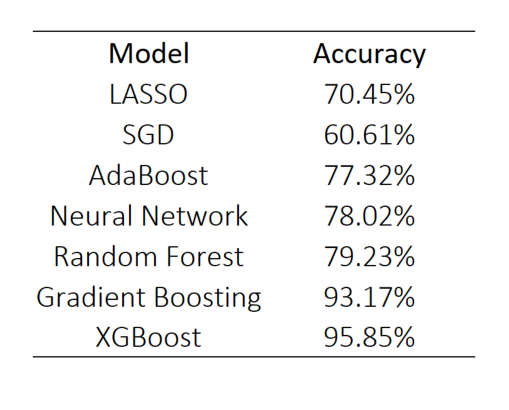

In [12]:
Image(filename="prediction result.png", embed=True, width=250)

The winner appears to be XGBoost with the following setting: 

xgb.XGBClassifier(n_estimators= 160, max_depth= 10, objective= 'binary:logistic', n_jobs= -1)

For details on testing models' performance, check here: 

https://github.com/fffdong/SpringBoard-Capstone-Project/blob/master/Tune%20Parameter%20and%20Fit%20Model.ipynb
https://github.com/fffdong/SpringBoard-Capstone-Project/blob/master/Fit%20Model%20by%20Quarter.ipynb

In [1]:
import xgboost as xgb

In [10]:
def to_int(df, var):
    df[var] = df[var].astype(int)
    return df

In [20]:
for var in ['book_month', 'book_year', 'book_weekday']:
    X_Q24 = to_int(X_Q24, var)
    X_Q1 = to_int(X_Q1, var)
    X = to_int(X, var)

In [25]:
cross_val_score(xgb.XGBClassifier(n_estimators= 160, max_depth= 10, objective= 'binary:logistic', n_jobs= -1), X, y, scoring='roc_auc', cv=4).mean()

0.95851595929893896

Using 4-fold CV, XGBoost achieved an accuracy score of 95.85%, indicating that the model predicted 95.85% of the test cases correctly.

This accuracy score sounds too good to be true. After all, while very helpful, one single metric cannot give us the full picture. Let's dig deeper and better understand the performance of our model.

## V. Model Analysis
### A. Predict the future
Train a model using 2015 and 2016's data and predict 2017's availability.

Based on what we learned from Model Fitting, we will use XGBoost Classifier here.

In [ ]:
dat_1516 = allData[allData['book_year']!='2017']
dat_17 = allData[allData['book_year']=='2017']

In [8]:
clf = xgb.XGBClassifier(n_estimators= 160, max_depth= 10, objective= 'binary:logistic', n_jobs= -1)

In [9]:
def to_int(df, var):
    df[var] = df[var].astype(int)
    return df

In [149]:
X = dat_1516.drop('target', axis=1)
y = dat_1516['target']
test = dat_17.loc[(dat_17['book_month'].isin(['1','2','3','4','5','6']))]
X_test = test.drop('target', axis=1)
y_test = test['target']
for var in ['book_month', 'book_year', 'book_weekday']:
    X = to_int(X, var)
    X_test = to_int(X_test, var)
clf.fit(X, y)
clf.score(X_test, y_test)

0.9563342166093477

The accuracy score looks relatively high. However, we must be cautious with this result. Let's first take a look at the **confusion matrix** of our model.

In [24]:
from sklearn.metrics import confusion_matrix

In [25]:
confusion_matrix(y_test, y_pred_bin)

array([[49348,  1692],
       [ 1406, 18502]])

[True Negative, False Positive]

[False Negative, True Positive]

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_bin, target_names=['unavailable', 'available']))

             precision    recall  f1-score   support

unavailable       0.97      0.97      0.97     51040
  available       0.92      0.93      0.92     19908

avg / total       0.96      0.96      0.96     70948



It seems like the model is more accurate in predicting 'unavailability'. **That is, the model can accurately urge guests to book their apartments in advance; however, for hosts who want to know when their places will be unavailable and plan accordingly, the model is less accurate.** 

## A real life senario
As a guest, I want to book a place through Airbnb in advance. That is, I am using today's listing information to predict its availability in two months. What's the relation between accuracy score and the number of days I book a place in advance?

In [145]:
later_use = pd.read_csv('later.txt', sep=" ", dtype = dtype_dict_ready, encoding = "ISO-8859-1")
allData_avail = pd.concat([allData, later_use], axis=1)
dat_17_avail = allData_avail[allData_avail['book_year']=='2017']
test_avail = dat_17_avail.loc[(dat_17_avail['book_month'].isin(['1','2','3','4','5','6']))]

In [147]:
test_avail = test_avail[(test_avail.book_week >=1) & (test_avail.book_week <=24)]
month_dict = test_avail[['book_month', 'book_week']]
month_dict.drop_duplicates(inplace=True)
month_dict = dict(zip(month_dict['book_week'], month_dict['book_month']))

In [42]:
target_dict = test_avail[['listing_id', 'book_week', 'book_month']]

In [43]:
target_dict['id'] = target_dict.apply(lambda x: '-'.join(x.astype(str)), axis=1)

In [47]:
target_dict['target'] = test_avail['target']
target_dict = dict(zip(target_dict['id'], target_dict['target']))

In [111]:
accuracy = []
report = []

Since our data are updated monthly. Let's calculate the corresponding accuracy rate if I want to book 5 / 10 / 15 / 20 weeks in advance.

In [112]:
for i in list(range(5, 25, 5)):
    test_avail['book_week2'] = test_avail['book_week'] + i
    test_avail['book_month2'] = test_avail.book_week2.replace(month_dict)
    temp = test_avail.drop(['avail_365', 'avail_60', 'avail_90'], axis = 1)
    temp = temp.loc[temp.book_week2<=24]
    temp['id'] = temp[['listing_id', 'book_week2', 'book_month2']].apply(lambda x: '-'.join(x.astype(str)), axis=1)
    y_temp = temp.id.replace(target_dict)
    y_temp = y_temp == 1
    temp['book_month'] = temp['book_month2']
    temp['book_week'] = temp['book_week2']
    temp.drop(['listing_id', 'book_month2', 'book_week2', 'target', 'id'], axis = 1, inplace=True)
    for var in ['book_month', 'book_year', 'book_weekday']:
        temp = to_int(temp, var)
    y_pred = clf.predict(temp)
    accuracy.append(metrics.accuracy_score(y_temp, y_pred))
    report.append(classification_report(y_temp, y_pred, target_names=['unavailable', 'available']))

Accuracy drops to the 70s, this is the true accuracy score of our model, as in reality, we only have access to listing information as of our **booking date**, rather than **check-in date**.

As the plot below shows, the earlier we book the listing, the less accurate the model is (from 0.78 to 0.72). The further into the future, the harder to predict. 

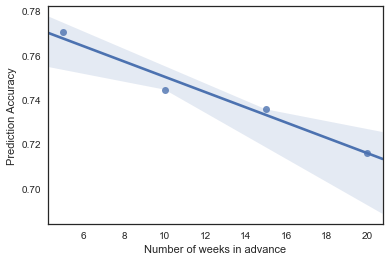

In [120]:
sns.set_style("white")
sns.regplot(x=pd.Series([5, 10, 15, 20]), y=pd.Series(accuracy))
plt.xlabel('Number of weeks in advance')
plt.ylabel('Prediction Accuracy')

Take a deeper look at our results. Let i be the number of weeks we book in advance. The table below lists the precision and recall for i = 5/10/15/20.

In [114]:
for i in list(range(0, 4)):
    print(i*5+5)
    print(report[i])

5
             precision    recall  f1-score   support

unavailable       0.84      0.84      0.84     37554
  available       0.58      0.60      0.59     14420

avg / total       0.77      0.77      0.77     51974

10
             precision    recall  f1-score   support

unavailable       0.83      0.82      0.82     27835
  available       0.53      0.56      0.54     10495

avg / total       0.75      0.74      0.75     38330

15
             precision    recall  f1-score   support

unavailable       0.83      0.81      0.82     18216
  available       0.49      0.54      0.51      6427

avg / total       0.74      0.74      0.74     24643

20
             precision    recall  f1-score   support

unavailable       0.82      0.79      0.80      8127
  available       0.46      0.52      0.48      2821

avg / total       0.73      0.72      0.72     10948



Similar to our results above, the model is more accurate in predicting 'unavailability'. When i >= 15, we can only get half our the 'available' cases right. Again, **our model is better at guiding guests to book their apartments in advance.**

### B. Feature Importance

In [30]:
importance = pd.DataFrame()

In [32]:
importance['features'] = X.columns.values
importance['importance'] = clf.feature_importances_
importance = importance.sort_values(by='importance', ascending=False)

#### 15 Most Important Features

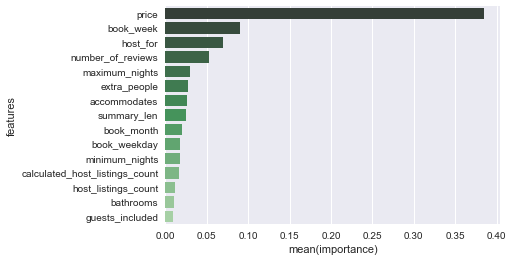

In [41]:
sns.barplot(y="features", x="importance", data=importance.iloc[0:15,:], palette="Greens_d")

#### 15 Most Unimportant Features

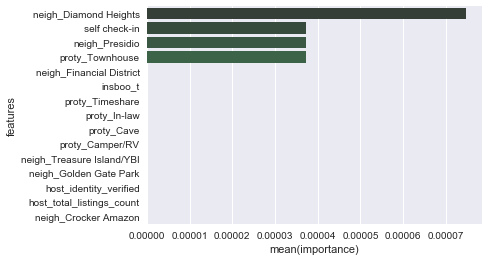

In [43]:
sns.barplot(y="features", x="importance", data=importance.iloc[len(importance)-15:len(importance),:], palette="Greens_d")

#### 10 Most Important Amenities

In [203]:
amenities = importance.iloc[18:43, :]
amenities = amenities.sort_values(by='importance', ascending=False)

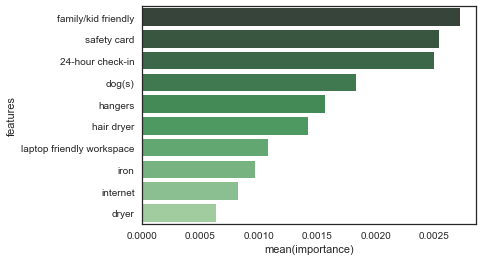

In [204]:
sns.barplot(y="features", x="importance", data=amenities.iloc[len(amenities)-10:len(amenities),:], palette="Greens_d")

#### The Neighborhoods that matter

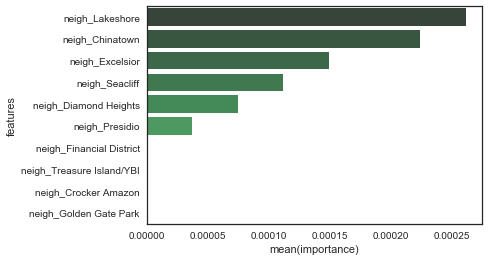

In [208]:
neighborhood = importance.iloc[57:93, :]
neighborhood = neighborhood.sort_values(by='importance', ascending=False)
sns.barplot(y="features", x="importance", data=neighborhood.iloc[len(neighborhood)-10:len(neighborhood),:], palette="Greens_d")

## VI. Model Application

### A Guest's Perspective

Now let's walk through a real-life application of our model. Suppose we want to book this "Spacious, clean, quiet suite" from June 25, 2019 to June 30, 2019 for a work trip. The place is not available for booking yet. We want to know that if we come back in early June 2019, will this place be available for the period of time we want?

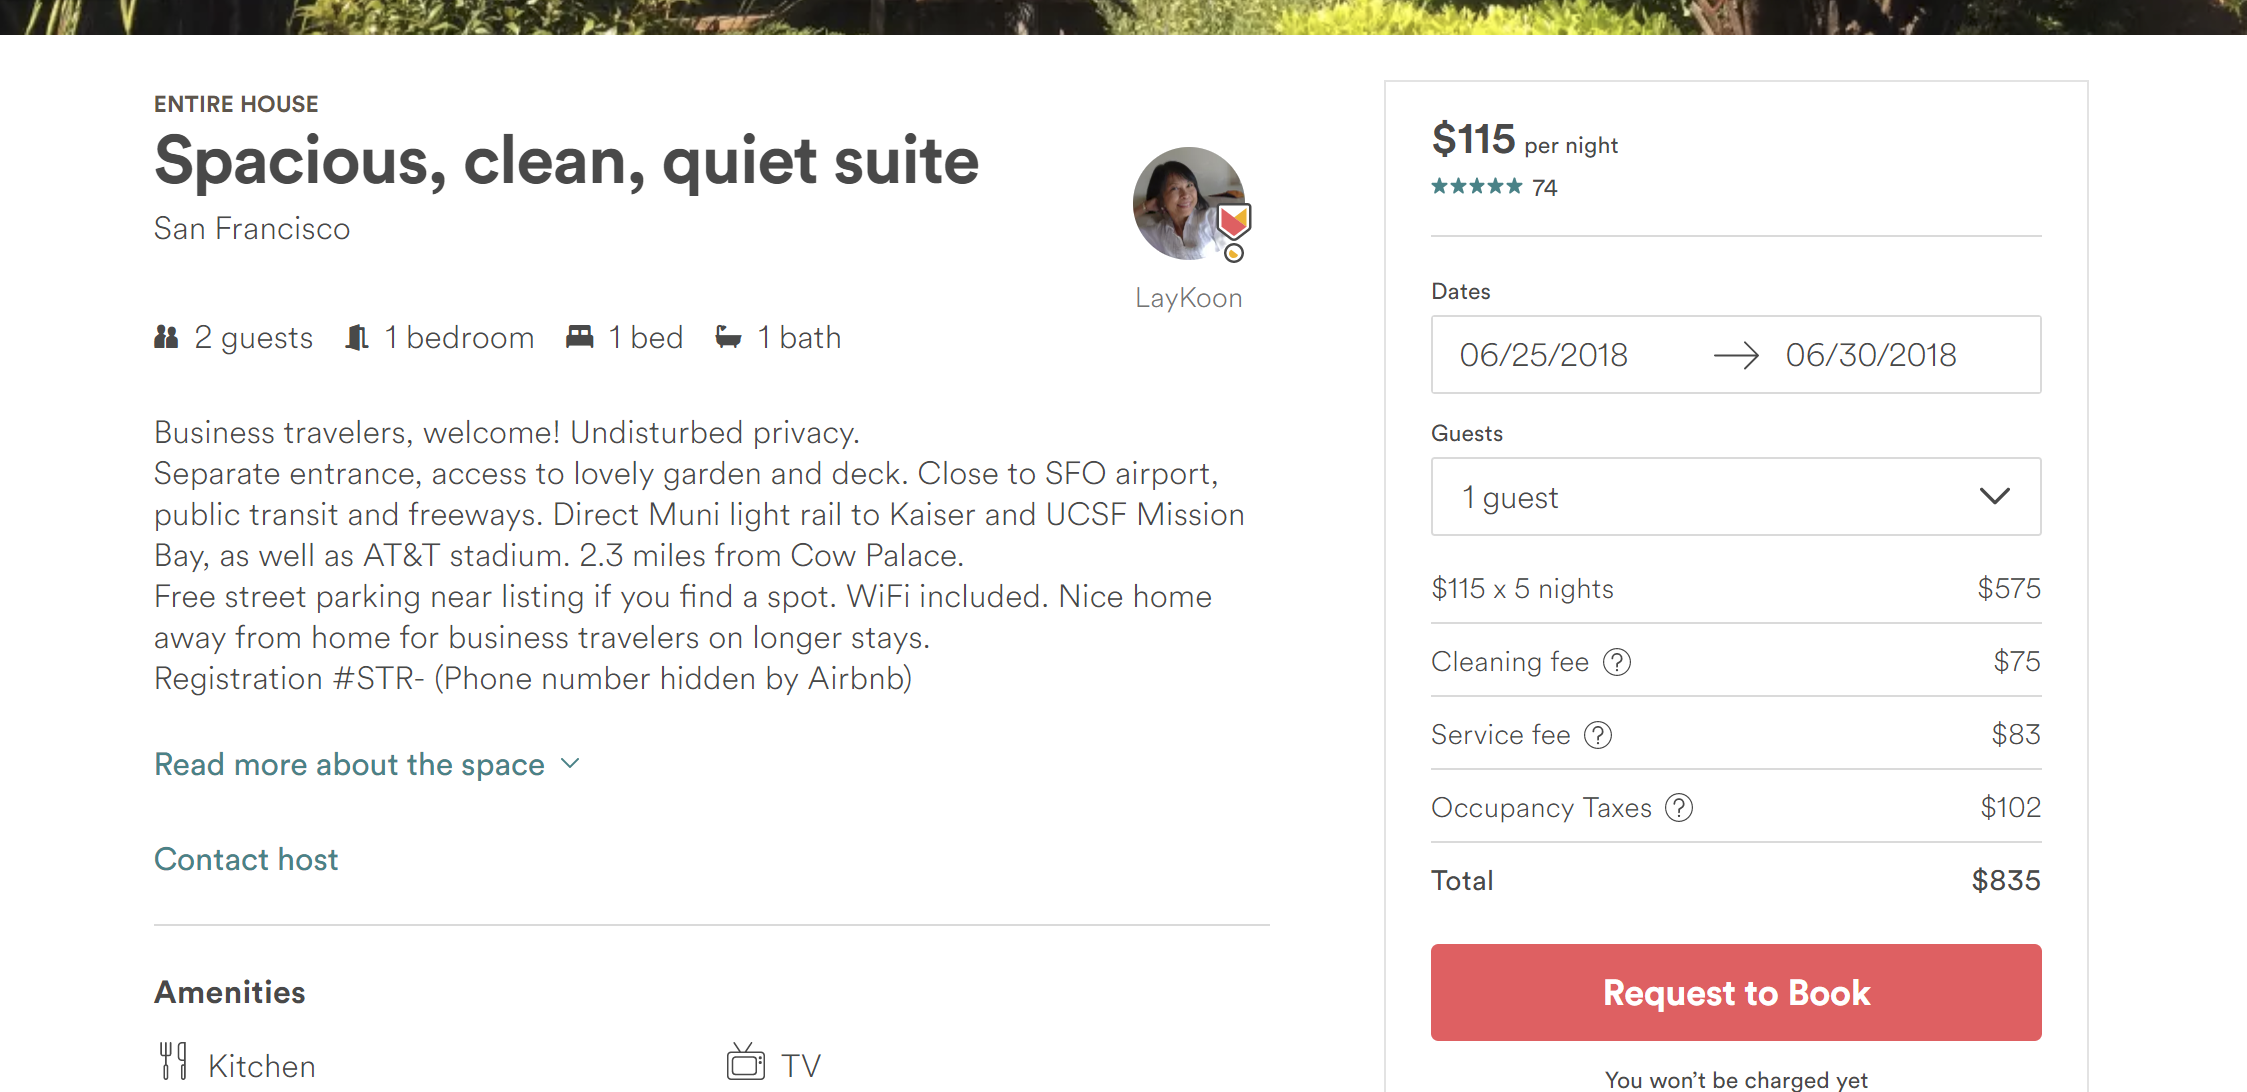

In [9]:
from IPython.display import Image
Image(filename="airbnb example 2.png", embed=True)

To use our model to answer this question, first, we have to turn this listing's information to something our model can read: a dataframe whose columns match the features in our prediction model. The table below summarises the key information used by our model. 

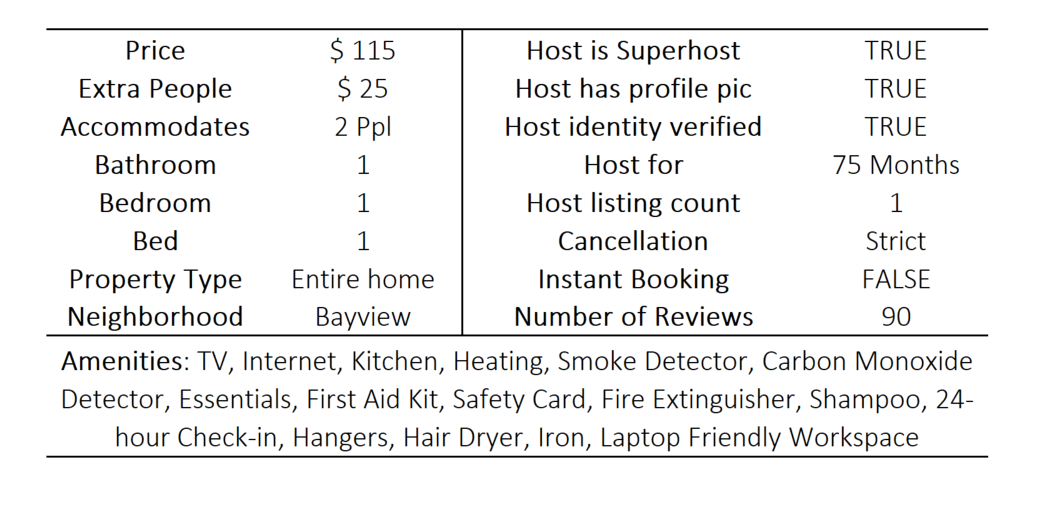

In [11]:
Image(filename="airbnb listing table2.png", embed=True, width=500)

Since we don't know what the per-night price will be in June 2019, or how many reviews this apartment will receive by that time, we do our best to make an educated guess. For June 25, 2018, the host sets the price to be $115, similar to the prices at similar time periods in 2016 and 2017, so we use the average price of the historical data (Tues ~ Sun, the 26th week of the 2016 and 2017) to be the hypothetical price. As of March 2013, the host has been on Airbnb for exactly 5 years with 73 reviews, roughly 15 reviews per year; so we assume by June 2019, she will receive 90 reviews. The tangible features of the listing, such as # of bathroom/bedroom, property type, amenities and neighborhood, are expected to stay the same. 

The test set for June 25 2019 ~ June 30 2019 is loaded below. Let's take a look at the data frame.

In [211]:
real_case_whole = pd.read_csv('testing_whole_summer.csv')

In [212]:
alltest = allData_avail[(allData_avail.listing_id == 4215907) & (allData_avail.book_week>=23) & (allData_avail.book_week<=35)]
price_hypo = alltest.groupby(['book_week', 'book_weekday'])['price'].mean().reset_index().price
real_case_whole['price'] = price_hypo.copy()

In [141]:
real_case = real_case_whole[(real_case_whole.book_week==26) & (real_case_whole.book_weekday>0)]

All the date-related variables (holiday, book_month, book_weekday, weekend, book_week, host_for) are tailored for our planned booking date.

Train the XGBoost Model using all available data we have (September 2015 to September 2017).

In [10]:
X = allData.drop('target', axis=1)
y = allData['target']
clf = xgb.XGBClassifier(n_estimators= 160, max_depth= 10, objective= 'binary:logistic', n_jobs= -1)
for var in ['book_month', 'book_year', 'book_weekday']:
    X = to_int(X, var)
clf.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=160,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)



**Now it's time for prediction!** Fit the trained model on our real case test set.

In [142]:
real_case_pred = clf.predict(real_case)

In [143]:
real_case_pred

array([0, 0, 0, 0, 0, 0], dtype=int8)

The prediction result returns six '0's, indicating that all six days of June 25 2019 to June 30 2019 will be booked! So it is better for the guest to book this 'Spacious, clean and quiet suite' way in advance: our model shows that it is a hot sale!

**Note:** One limitation of this model is that it is unable to predict the availability status of a listing dynamically. Because we don't have data on how the availability calendar of a listing has changed over time, i.e., exactly on what day has a booking/cancellation taken place, we are unable to predict how long do I need to book in advance so that it is guaranteed that I can get this place. Answering this question requires scraping availability calendar daily from Airbnb, a laborious task which is unlikely to be completed by anyone but Airbnb (to be fair, Airbnb does not need to do anything in particular; they own these data). This may potentially be a good feature for Airbnb's hosts: by knowing that when their listing will be booked (before the actual booking takes place), hosts can make financial plans in advance and figure out ways to boost booking rate for unpopular season.

### A Host's Perspective

Suppose LayKoon, the host of this listing, is using our model. She wants the model to answer the following questions:

 - How's my place's booking rate for the summer?
 - How will the booking rate/total revenue change if I adjust the price?
 
Let's first predict LayKoon's place's availability for summer 2019. Similar to the example above, we construct a dataframe whose columns match the features in the model. For simplicity, here we define summer time to be June 3 2019 ~ September 1 2019 (week 23 ~ week 35).

In [155]:
real_case_whole.head(n=8)

,accommodates,bathrooms,bedrooms,beds,calculated_host_listings_count,extra_people,guests_included,host_has_profile_pic,host_identity_verified,host_is_superhost,...,has_transit,has_host,summary_len,holiday,host_for,book_month,book_year,book_weekday,weekend,book_week
0,2,1,1,1,1,25,1,True,True,True,...,0,0,394,False,75,6,2019,0,False,26
1,2,1,1,1,1,25,1,True,True,True,...,0,0,394,False,75,6,2019,1,False,26
2,2,1,1,1,1,25,1,True,True,True,...,0,0,394,False,75,6,2019,2,False,26
3,2,1,1,1,1,25,1,True,True,True,...,0,0,394,False,75,6,2019,3,False,26
4,2,1,1,1,1,25,1,True,True,True,...,0,0,394,False,75,6,2019,4,True,26
5,2,1,1,1,1,25,1,True,True,True,...,0,0,394,False,75,6,2019,5,True,26
6,2,1,1,1,1,25,1,True,True,True,...,0,0,394,False,75,6,2019,6,False,26
7,2,1,1,1,1,25,1,True,True,True,...,0,0,394,False,75,6,2019,0,False,23


In [5]:
real_case_whole.shape

(91, 123)

The test set has 91 rows, which correspond to 91 days in the set period (week 23 ~ week 35). For initial prediction of booking rate, we set price to be the average price of the historical data (week 23 ~ week 35 of 2016 and 2017). The hypothetical price was chosen out of two considerations: 1). To account for price variation across weekdays and weeks; 2). After examing the historical data, summer prices in 2016 and 2017 follow a similar trend. It is highly likely that the host will set the price similarly in 2019. We assume LayKoon receives 90 reviews by the end of June, 95 by the end of July and 100 by the end of August. 

**Time for prediction!** Let's fit the trained model to our test set.

In [187]:
real_whole_pred = clf.predict(real_case_whole)

In [188]:
real_whole_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0], dtype=int8)

The detailed prediction for every single day is shown above. (Note: the dataframe real_case_whole starts from rows of week 26, followed by rows of week 23~25, week 27~35. So the first seven 0s are prediction results for week 26, which is in line with the result in 'A Guest's Perspective')

We can calculate **the booking rate** of LayKoon's place, which is 59.3%.

In [189]:
# Calculate Booking Rate
1 - sum(real_whole_pred)/91

0.5934065934065934

Let's then calcualte LayKoon's **projected revenue** for Summer 2019.

In [192]:
di1 = {1: "a", 0: "b"}
di2 = {"a": 0, "b":1}
def calc_revenue(series):
    series = pd.DataFrame(series)
    series['price'] = real_case_whole['price']
    series.rename(columns={0: "pred"}, inplace=True)
    # Reverse the 0/1 mapping of target variable. Let y=0 when 'available' and y=1 when 'unavailable', 
        # so that it is easier for listing value calculation.
    series = series.replace({"pred": di1})
    series = series.replace({"pred": di2})
    return(sum(series['pred']*series['price']))

In [193]:
calc_revenue(real_whole_pred)

6310.181074766358

Our model predicts that LayKoon's place can earn **$6310** in Summer 2019!

Naturally, we come to this next question: how can LayKoon increase her revenue? **Let's see how her total revenue changes with the price.** We show two examples here.

- Price decrease

Say we decrease the price by 10 dollars.

In [363]:
real_case_whole['price'] = price_hypo - 10

In [364]:
pred_adj_price = clf.predict(real_case_whole)

In [365]:
1-sum(pred_adj_price)/91

0.29670329670329665

In [366]:
calc_revenue(pred_adj_price)

2987.2535046728967

It appears that the booking rate actually decreases to 30%, as well as the total revenue. 

- Price increase

In [367]:
# By 25%
real_case_whole['price'] = price_hypo * 1.25
pred_adj_price = clf.predict(real_case_whole)
1-sum(pred_adj_price)/91

0.46153846153846156

In [368]:
calc_revenue(pred_adj_price)

6189.998539719625

In [381]:
# By 40%
real_case_whole['price'] = price_hypo * 1.4
pred_adj_price = clf.predict(real_case_whole)
1-sum(pred_adj_price)/91

0.4725274725274725

In [382]:
calc_revenue(pred_adj_price)

7154.976401869164

As we increase price, booking rate drops. So we need a relatively large increase in order to make up for the drop in booking rate. In our case, it is around 40%.

To sum up, if LayKoon keeps her current pricing-strategy, her apartment is expected to be 60% booked for Summer 2019 and earn LayKoon more than $6000. Historical data show that LayKoon's strategy has been pretty consistent and conservative. It is worth for her to be a bit more aggressive and increase the price for at least a few weeks in the summer - there is a high chance she can earn more. 

## VII. Conclusion

In this project, we used XGBoost to build a binary prediction model that predicts Airbnb listings' availability in San Francisco. Monthly-scraped Airbnb data from September 2015 to September 2017 are used to train and test the model. The model achieves relatively high accuracy score (95.85% using standard 4-fold CV, 78% in a more realistic setting (see 'A Real Life Scenario' for more details)) and can serve as a useful tool for Airbnb hosts and guests in guiding their renting/booking strategies. 

For future data scientists who are interested in improving this model, there are a few pathways worth exploring: 1). get more data and train the model for a longer period of time / for other cities. At the early stage of this project, San Francisco was the most frequently updated city on insideairbnb.com and we could only go as far back as September 2015. Given more time, the data availability issue will certainly be improved and more interesting models can be built then. 2). As noted in the Model Application section, one limitation of this model is its inability to do dynamic prediction. While we do know how the availability calendar changes on a monthly basis, it is not very useful for real-life application. Hopefully, Airbnb could share some of its availability data with the public, a lot more interesting projects can be done then. Or, Airbnb can consider introducing this 'Booking Projection' feature itself. By knowing when a listing will be booked (before the actual booking takes place), hosts / guests can plan their finance / travel much more wisely. 3). While we have pretty detailed geographic information of the listings, this model did not do much with it other than turning them into dummy variables and throwing it into the model. With the appropriate GIS tool/data, spatial analysis can be done and integrated to the model to obtain location-based insights, so that we can answer questions like 'can I attract more guests if my place is next to the BART/good restaurants/park...etc.?'

## VIII. Appendix

### A complete list of features

In [39]:
features.columns.values

array(['accommodates', 'bathrooms', 'bedrooms', 'beds',
       'calculated_host_listings_count', 'extra_people', 'guests_included',
       'host_has_profile_pic', 'host_identity_verified',
       'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'maximum_nights', 'minimum_nights',
       'number_of_reviews', 'require_guest_phone_verification',
       'require_guest_profile_picture', 'requires_license', 'tv',
       'internet', 'kitchen', 'pets live on this property', 'dog(s)',
       'indoor fireplace', 'heating', 'family/kid friendly',
       'smoke detector', 'carbon monoxide detector', 'essentials',
       'washer', 'dryer', 'buzzer/wireless intercom', 'first aid kit',
       'safety card', 'fire extinguisher', 'shampoo',
       'free parking on premises', 'breakfast', '24-hour check-in',
       'hangers', 'hair dryer', 'iron', 'laptop friendly workspace',
       'self check-in', 'cancel_flexible', 'cancel_moderate',
       'cancel_strict', 'cancel_supe